##### Downloading libraries 

In [53]:
import heapq 
import pandas as pd
import json
import matplotlib.pyplot as plt

##### Print cities and connections

In [5]:
with open('2324_GIA04_CA5_Search_data_routes.json') as json_file:
    data = json.load(json_file)

cities = data['cities']
connections = data['connections']

for city in cities:
    print("Name:", city['name'])
    print("Address:", city['address'])
    print("Country:", city['country'])
    print("Latitude:", city['latitude'])
    print("Longitude:", city['longitude'])
    print()

for connection in connections:
    print("From:", connection['from'])
    print("To:", connection['to'])
    print("Distance:", connection['distance'])
    print("Duration:", connection['duration'])
    print()

Name: Barcelona
Address: Barcelona, Spain
Country: ES
Latitude: 41.3850639
Longitude: 2.1734035

Name: Granollers
Address: Granollers, Barcelona, Spain
Country: ES
Latitude: 41.60619270000001
Longitude: 2.2870889

Name: L'Hospitalet de Llobregat
Address: L'Hospitalet de Llobregat, Barcelona, Spain
Country: ES
Latitude: 41.3661865
Longitude: 2.1164942

Name: MatarÃ³
Address: MatarÃ³, Barcelona, Spain
Country: ES
Latitude: 41.5381124
Longitude: 2.4447406

Name: Vic
Address: 08500 Vic, Barcelona, Spain
Country: ES
Latitude: 41.9304373
Longitude: 2.2544335

Name: PalamÃ³s
Address: PalamÃ³s, Girona, Spain
Country: ES
Latitude: 41.8505066
Longitude: 3.1298161

Name: Tremp
Address: 25620 Tremp, Lleida, Spain
Country: ES
Latitude: 42.1669147
Longitude: 0.8949296

Name: Sort
Address: Sort, Lleida, Spain
Country: ES
Latitude: 42.43785039999999
Longitude: 1.0873551

Name: Reus
Address: Reus, Tarragona, Spain
Country: ES
Latitude: 41.1498259
Longitude: 1.1055321

Name: Blanes
Address: 17300 Blanes

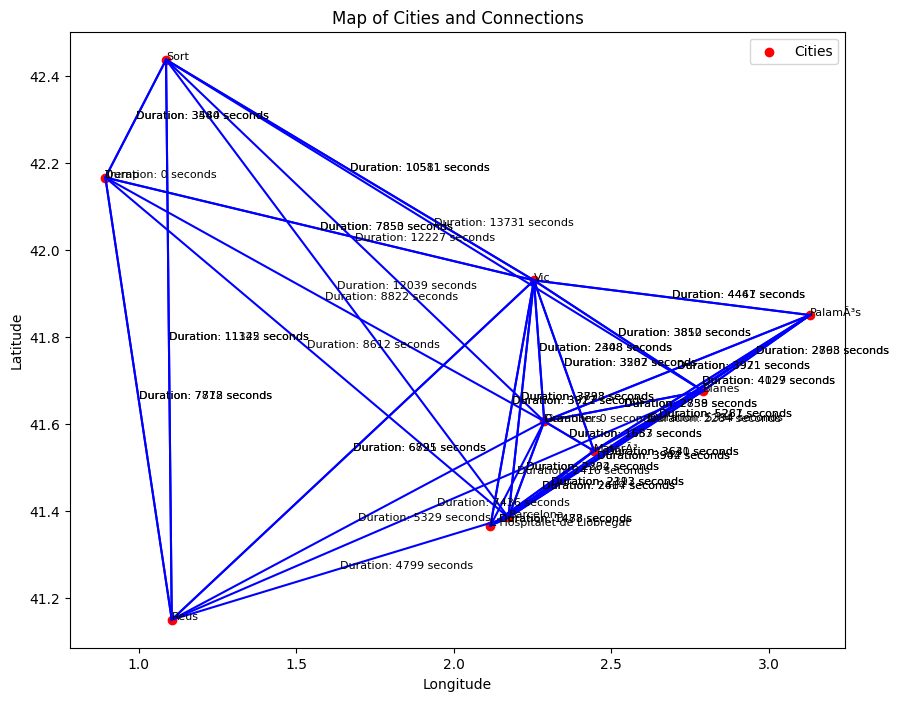

In [34]:
# Load the JSON data from the file
with open('2324_GIA04_CA5_Search_data_routes.json') as json_file:
    data = json.load(json_file)

# Convert JSON data to DataFrames for cities and connections
dfcities = pd.DataFrame(data['cities'])
dfconnections = pd.DataFrame(data['connections'])

# Assuming you want to create a map with just cities and connections without using GeoPandas

# Create a larger figure
plt.figure(figsize=(10, 8))

# Plot cities
plt.scatter(dfcities['longitude'], dfcities['latitude'], color='red', label='Cities')

# Plot connections
for i, connection in dfconnections.iterrows():
    from_city = dfcities[dfcities['name'] == connection['from']]
    to_city = dfcities[dfcities['name'] == connection['to']]
    plt.plot([from_city['longitude'], to_city['longitude']], [from_city['latitude'], to_city['latitude']], 'b-')
    
    # Annotate each connection with its duration
    duration_text = f"Duration: {connection['duration']} seconds"
    plt.text((from_city['longitude'].values[0] + to_city['longitude'].values[0]) / 2, 
             (from_city['latitude'].values[0] + to_city['latitude'].values[0]) / 2, 
             duration_text, fontsize=8)

# Annotate each city with its name
for idx, row in dfcities.iterrows():
    plt.text(row['longitude'], row['latitude'], row['name'], fontsize=8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Cities and Connections')
plt.legend()
plt.show()


### A*

In [52]:
#Algorithm A * on graphs:
#  1. Let L be alist of the initial nodes of the problem.
#  o Otherwise, let n be the node of L such that f (n) = g(n) + h '(n) is minimal.
#  3. If n is a target node, then stop and return it together with the path from the initial node
#  to it.
#  o If not, delete n.
#  4.Expand n adding all its children to L. Each child will be labeled with the path traveled
#  from the initial node to it.
#  5.If a child is already in the list, then relabel it with the best value of f(n) (keep the best).
#  6.Go back to step 2

def a_star(start, goal, graph, heuristics):
    """
    Perform the A* algorithm to find the shortest path from start_node to stop_node.

    :param start_node: The starting node.
    :param stop_node: The goal node.
    :param graph: A dictionary representing the graph with nodes as keys and 
                  lists of tuples (neighbor, cost) as values.
    :param heuristics: A dictionary representing the heuristic values for each node.
    :return: The shortest path and its cost.
    """
    L = []
    heapq.heappush(L, (0 + heuristics[start], 0, start, [start]))
    explored = set()

    while L:
        f, g, current_node, path = heapq.heappop(L)
        
        if current_node in explored:
            continue
        
        if current_node == goal:
            return path, g
        
        explored.add(current_node)
        
        for (neighbor, time) in graph[current_node]:
            if neighbor in explored:
                continue
            
            new_g = g + time
            new_f = new_g + heuristics[neighbor]
            new_path = path + [neighbor]
            
            heapq.heappush(L, (new_f, new_g, neighbor, new_path))
            
    return None, float('inf')


# Load the JSON data from the file
with open('2324_GIA04_CA5_Search_data_routes.json') as json_file:
    data = json.load(json_file)

# Convert JSON data to DataFrames for cities and connections
dfcities = pd.DataFrame(data['cities'])
dfconnections = pd.DataFrame(data['connections'])

# Create a graph from the data
graph = {}
for idx, row in dfcities.iterrows():
    graph[row['name']] = []

for idx, row in dfconnections.iterrows():
    graph[row['from']].append((row['to'], row['distance']))

# Define heuristic values (for demonstration purposes, these should be based on actual estimates)
heuristics = {row['name']: row['latitude'] + row['longitude'] for idx, row in dfcities.iterrows()}

# Example start and goal nodes
start = 'Blanes'
goal = 'Barcelona'

# Running the A* algorithm
path, cost = a_star(start, goal, graph, heuristics)

print(f"Path: {path}")
print(f"Cost: {cost}")

Path: ['Blanes', 'Barcelona']
Cost: 72777


### CSP Constraint Satisfaction Problem

In [54]:
def csp_solver(start, goal, graph, max_distance, max_duration, max_stages=3):
    """
    Solve the CSP problem to find a path from start to goal while satisfying constraints.

    :param start: The starting node.
    :param goal: The goal node.
    :param graph: A dictionary representing the graph with nodes as keys and 
                  lists of tuples (neighbor, distance, duration) as values.
    :param max_distance: Maximum total distance allowed for the path.
    :param max_duration: Maximum duration allowed for any stage (travel between intermediate cities).
    :param max_stages: Maximum number of stages (intermediate cities) allowed in the path.
    :return: The feasible path, its duration, and tracked stages, or None if no feasible path exists.
    """
    def backtrack(current_node, current_path, current_distance, current_duration, current_stages, tracked_stages):
        """
        Perform backtracking to explore paths and find a feasible solution.
        """
        if current_node == goal:
            return current_path, current_duration, tracked_stages

        if current_stages >= max_stages:
            return None

        for neighbor, distance, duration in graph[current_node]:
            if neighbor not in current_path:
                new_distance = current_distance + distance
                new_duration = current_duration + duration

                # Check if the constraints are satisfied
                if new_distance <= max_distance and new_duration <= max_duration:
                    new_path = current_path + [neighbor]
                    new_tracked_stages = tracked_stages + [(current_node, neighbor)]
                    result = backtrack(neighbor, new_path, new_distance, new_duration, current_stages + 1, new_tracked_stages)
                    if result:
                        return result

        return None

    # Start the backtracking process
    path = [start]
    distance = 0
    duration = 0
    stages = 0
    tracked_stages = []
    result = backtrack(start, path, distance, duration, stages, tracked_stages)

    return result

# Load the JSON data from the file
with open('2324_GIA04_CA5_Search_data_routes.json') as json_file:
    data = json.load(json_file)

# Convert JSON data to DataFrames for cities and connections
dfcities = pd.DataFrame(data['cities'])
dfconnections = pd.DataFrame(data['connections'])

# Create a graph from the data
graph = {}
for idx, row in dfcities.iterrows():
    graph[row['name']] = []

for idx, row in dfconnections.iterrows():
    graph[row['from']].append((row['to'], row['distance'], row['duration']))

# Example start and goal nodes
start = 'Blanes'
goal = 'Barcelona'

# Define constraints
max_distance = 1000000 # Maximum total distance in kilometers
max_duration = 90000  # Maximum duration between consecutive cities in minutes

# Running the CSP solver
result = csp_solver(start, goal, graph, max_distance, max_duration)

if result is not None:
    path, time, tracked_stages = result
    print(f"Feasible Path: {path}")
    print(f"Total Duration: {time}")
    print(f"Tracked Stages: {tracked_stages}")
else:
    print("No feasible path found that satisfies the given constraints.")



Feasible Path: ['Blanes', 'Barcelona']
Total Duration: 3630
Tracked Stages: [('Blanes', 'Barcelona')]


##link: https://www.linkedin.com/pulse/heuristics-search-technique-find-shortest-distance-between-pandeya